# A deep learning-based dual latent space method for the estimation of physical flow properties from fiber-optic measurements

#### Misael M. Morales
#### Alberto Mendoza, Kostyantyn Kravchenko, Andrea Rosales; Lytt Ltd
#### Michael Pyrcz, Carlos Torres-Verdin; UT Austin
***

In [1]:
from utils import *

check_tf()

2024-07-22 21:33:40.720665: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 21:33:40.720837: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 21:33:40.730353: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-22 21:33:40.755099: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



------------------------------------------------------------
----------------------- VERSION INFO -----------------------
TensorFlow version: 2.15.0 | TF Built with CUDA? True
# Device(s) available: 1 | CUDA: 12.0 | cuDNN: 8.6
Name(s): NVIDIA GeForce RTX 3090
------------------------------------------------------------



2024-07-22 21:33:43.098015: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-22 21:33:43.425170: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-22 21:33:43.425242: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-22 21:33:43.425938: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


***
Manually define flow matrices from file: SINTEF19_testmatrix.xlsx

- Background
- Gas calibration factor: m3/hr to cfd: =(35.3*24)
- Water Calibration factor from kg/s to bpd (=3.6/.0066)
- Oil calib factor for kg/s to bpd = ((3.6/.0066)/.782) for .782 oil density
- Oil calib factor for m3/hr to bpd = (1/.0066)

| (e.g., Exp 109) | Oil (bpd) | Gas (cfd) | Water (bpd) |   Sand    |
|       ---       |    ---    |    ---    |     ---     |    ---    |
| Background      |    6000   |    90000  |     0       |    0      |
| Injection 1     |    500    |    7500   |     0       |    0      |
| Injection 2     |    500    |    7500   |     0       |    0      |
| Injection 3     |    0      |    0      |     0       |    0      |
| Injection 4     |    0      |    0      |     500     |    10     |


In [2]:
exp45_flow = np.array([[1500, 0,    0, 0],
                        [250, 8250, 0, 0],
                        [250, 8250, 0, 0],
                        [0,   0,    0, 0],
                        [0,   0,    0, 0]])

exp48_flow = np.array([[3000,  0, 0,    0],
                        [500,  0, 0,    0],
                        [150,  0, 1500, 0],
                        [100,  0, 0,    0],
                        [5000, 0, 0,    0]])

exp54_flow = np.array([[1500, 50000,    0,    0],
                        [250, 8333.33,  1000, 0],
                        [250, 8333.33,  0,    0],
                        [0,   0,        0,    0],
                        [500, 16666.66, 1000, 0]])

exp64_flow = np.array([[3000, 100000,   0,    0],
                        [250, 8333.33,  250,  0],
                        [250, 8333.33,  100,  0],
                        [0,   0,        0,    0],
                        [250, 8333.33,  250,  0]])

exp109_flow = np.array([[6000, 90000,  0,   0],
                        [500,  7500,   0,   0],
                        [500,  7500,   0,   0],
                        [0,    0,      0,   0],
                        [0,    0,      500, 10]])

exp128_flow = np.array([[3000, 60000,  0,   0],
                        [500,  20000,  0,   0],
                        [500,  20000,  0,   0],
                        [0,    0,      0,   0],
                        [500,  20000,  0,   5]])

In [3]:
flow45_norm,  scaler45  = my_normalize(exp45_flow)
flow48_norm,  scaler48  = my_normalize(exp48_flow)
flow54_norm,  scaler54  = my_normalize(exp54_flow)
flow64_norm,  scaler64  = my_normalize(exp64_flow)
flow109_norm, scaler109 = my_normalize(exp109_flow)
flow128_norm, scaler128 = my_normalize(exp128_flow)

Original: (6, 5, 4) | Normalized: (6, 5, 4)


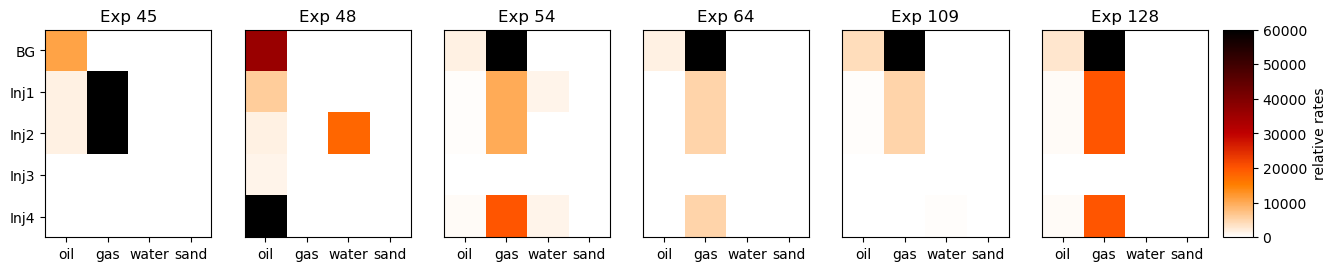

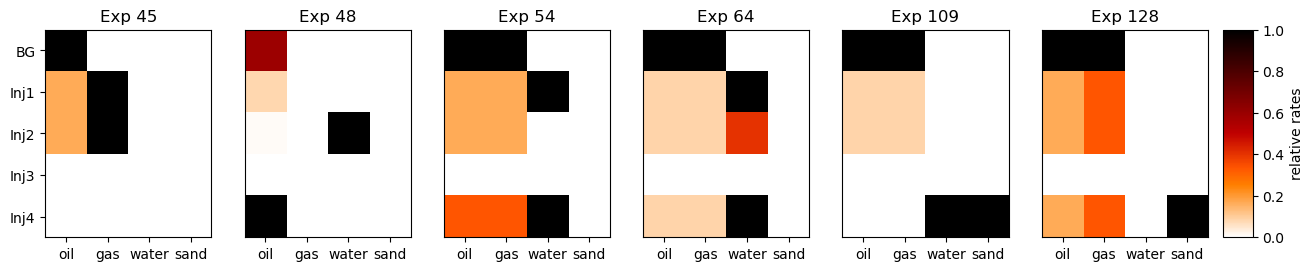

In [4]:
all_flow_orig = np.array([exp45_flow, exp48_flow, exp54_flow, exp64_flow, exp109_flow, exp128_flow])
all_flow_norm = np.array([flow45_norm, flow48_norm, flow54_norm, 
                          flow64_norm, flow109_norm, flow128_norm])

print('Original: {} | Normalized: {}'.format(all_flow_orig.shape, all_flow_norm.shape))
plot_relative_rates(all_flow_orig, cmap='gist_heat_r')
plot_relative_rates(all_flow_norm, cmap='gist_heat_r')

Individual Flow shapes: (200, 4) (200, 4) (200, 4) (200, 4) (200, 4) (200, 4)


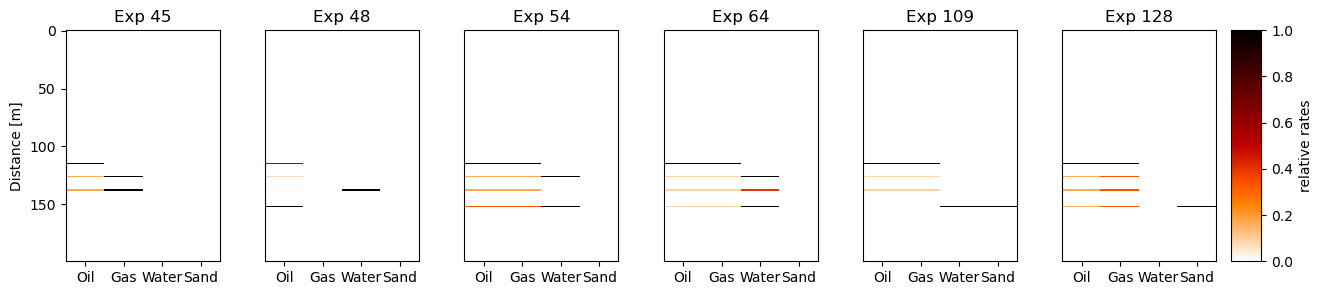

In [5]:
inj_idx = [115, 126, 138, 142, 152]

flow45  = make_sparse_flowrates(all_flow_norm[0], inj_idx)
flow48  = make_sparse_flowrates(all_flow_norm[1], inj_idx)
flow54  = make_sparse_flowrates(all_flow_norm[2], inj_idx)
flow64  = make_sparse_flowrates(all_flow_norm[3], inj_idx)
flow109 = make_sparse_flowrates(all_flow_norm[4], inj_idx)
flow128 = make_sparse_flowrates(all_flow_norm[5], inj_idx)
flow = np.array([flow45, flow48, flow54, flow64, flow109, flow128])

print('Individual Flow shapes:', flow45.shape, flow48.shape,  flow54.shape, 
                                 flow64.shape, flow109.shape, flow128.shape)
plot_relative_mat(flow, cmap='gist_heat_r')

In [6]:
das45,  dts45  = make_daslhs_dts('45')
das48,  dts48  = make_daslhs_dts('48')
das54,  dts54  = make_daslhs_dts('54')
das64,  dts64  = make_daslhs_dts('64')
das109, dts109 = make_daslhs_dts('109')
das128, dts128 = make_daslhs_dts('128')

print('45  - DAS: {} | DTS: {} | Flow: {}'.format(das45.shape, dts45.shape, flow45.shape))
print('128 - DAS: {} | DTS: {} | Flow: {}'.format(das128.shape, dts128.shape, flow128.shape))

45  - DAS: (78, 200, 1) | DTS: (78, 200, 1) | Flow: (200, 4)
128 - DAS: (93, 200, 1) | DTS: (93, 200, 1) | Flow: (200, 4)


In [30]:
print('45  - DAS: {} | DTS: {} | Flow: {}'.format(das45.shape, dts45.shape, flow45.shape))
print('48  - DAS: {} | DTS: {} | Flow: {}'.format(das48.shape, dts48.shape, flow48.shape))
print('54  - DAS: {} | DTS: {} | Flow: {}'.format(das54.shape, dts54.shape, flow54.shape))
print('64  - DAS: {} | DTS: {} | Flow: {}'.format(das64.shape, dts64.shape, flow64.shape))
print('109  - DAS: {} | DTS: {} | Flow: {}'.format(das109.shape, dts109.shape, flow109.shape))
print('128 - DAS: {} | DTS: {} | Flow: {}'.format(das128.shape, dts128.shape, flow128.shape))

45  - DAS: (78, 200, 1) | DTS: (78, 200, 1) | Flow: (200, 4)
48  - DAS: (78, 200, 1) | DTS: (78, 200, 1) | Flow: (200, 4)
54  - DAS: (114, 200, 1) | DTS: (114, 200, 1) | Flow: (200, 4)
64  - DAS: (82, 200, 1) | DTS: (82, 200, 1) | Flow: (200, 4)
109  - DAS: (106, 200, 1) | DTS: (106, 200, 1) | Flow: (200, 4)
128 - DAS: (93, 200, 1) | DTS: (93, 200, 1) | Flow: (200, 4)


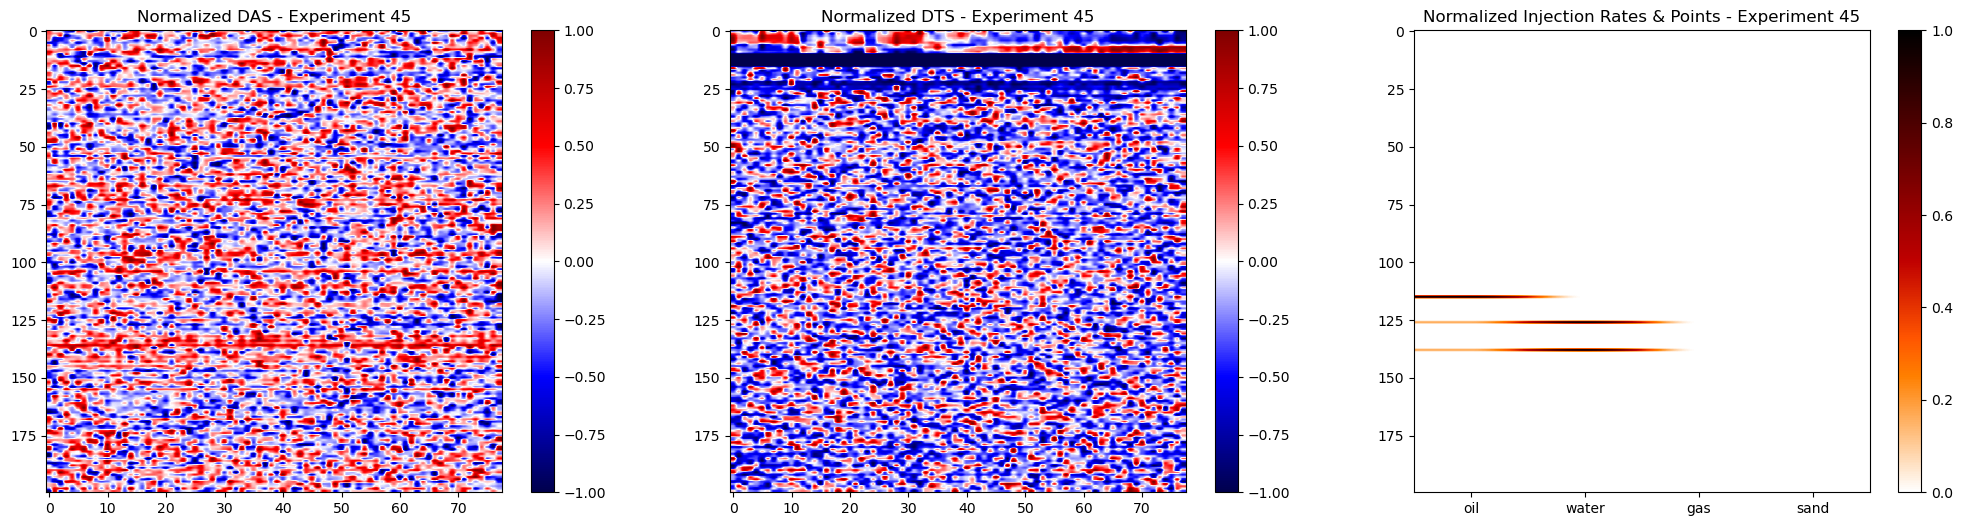

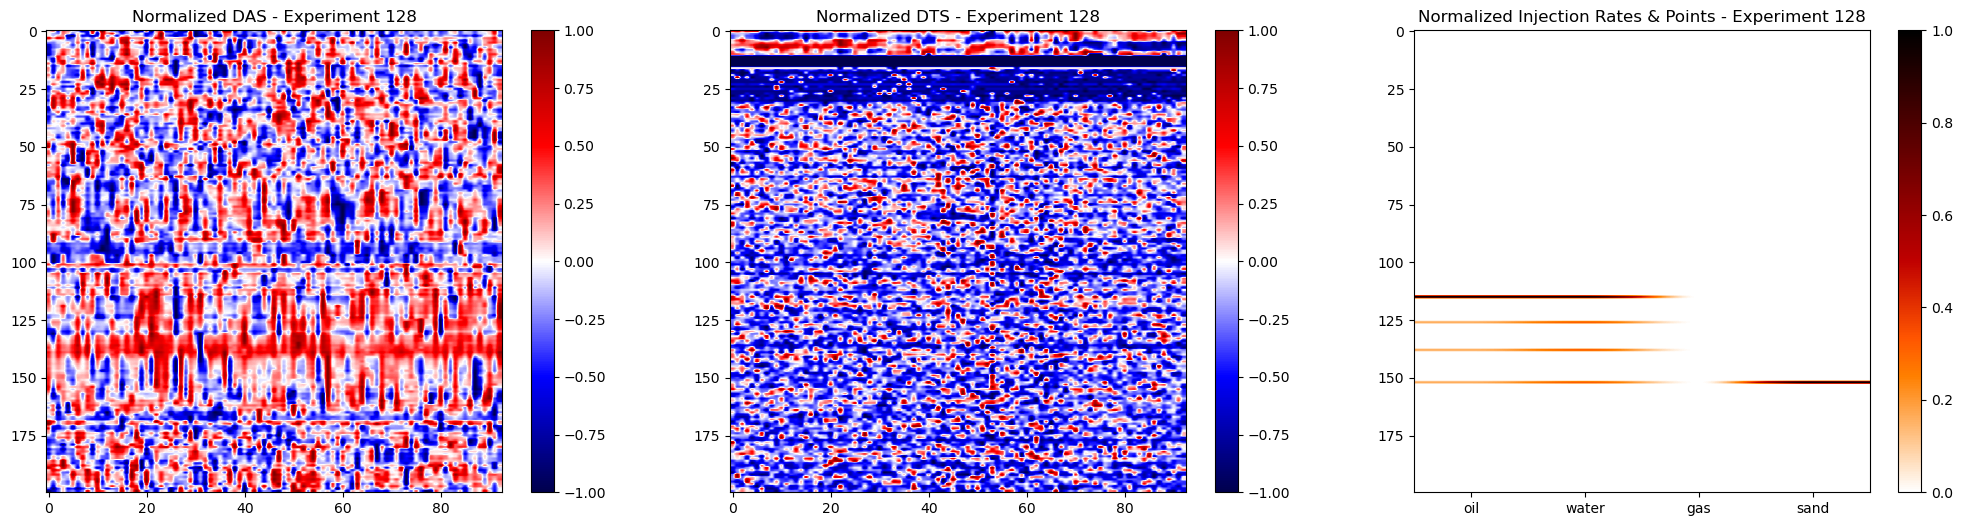

In [7]:
plot_das_dts_flow(das45,  dts45,  flow45,  expnum='45')
plot_das_dts_flow(das128, dts128, flow128, expnum='128')

***

2024-07-22 21:35:49.871701: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-22 21:35:49.871965: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-22 21:35:49.872017: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-22 21:35:50.132179: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-22 21:35:50.132357: I external/local_xla/xla/stream_executor

AutoEncoder # of parameters: 45,333
    Encoder # of parameters: 25,220


2024-07-22 21:35:57.904655: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-07-22 21:36:01.064383: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f54da900f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-22 21:36:01.064428: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-07-22 21:36:01.089774: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1721702161.222098   38086 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3/3 [==============================] - 1s 163ms/step
SSIM = 80.27
MSE  = 1.069e-02
PSNR = 25.73


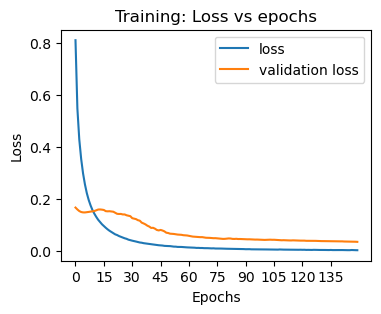

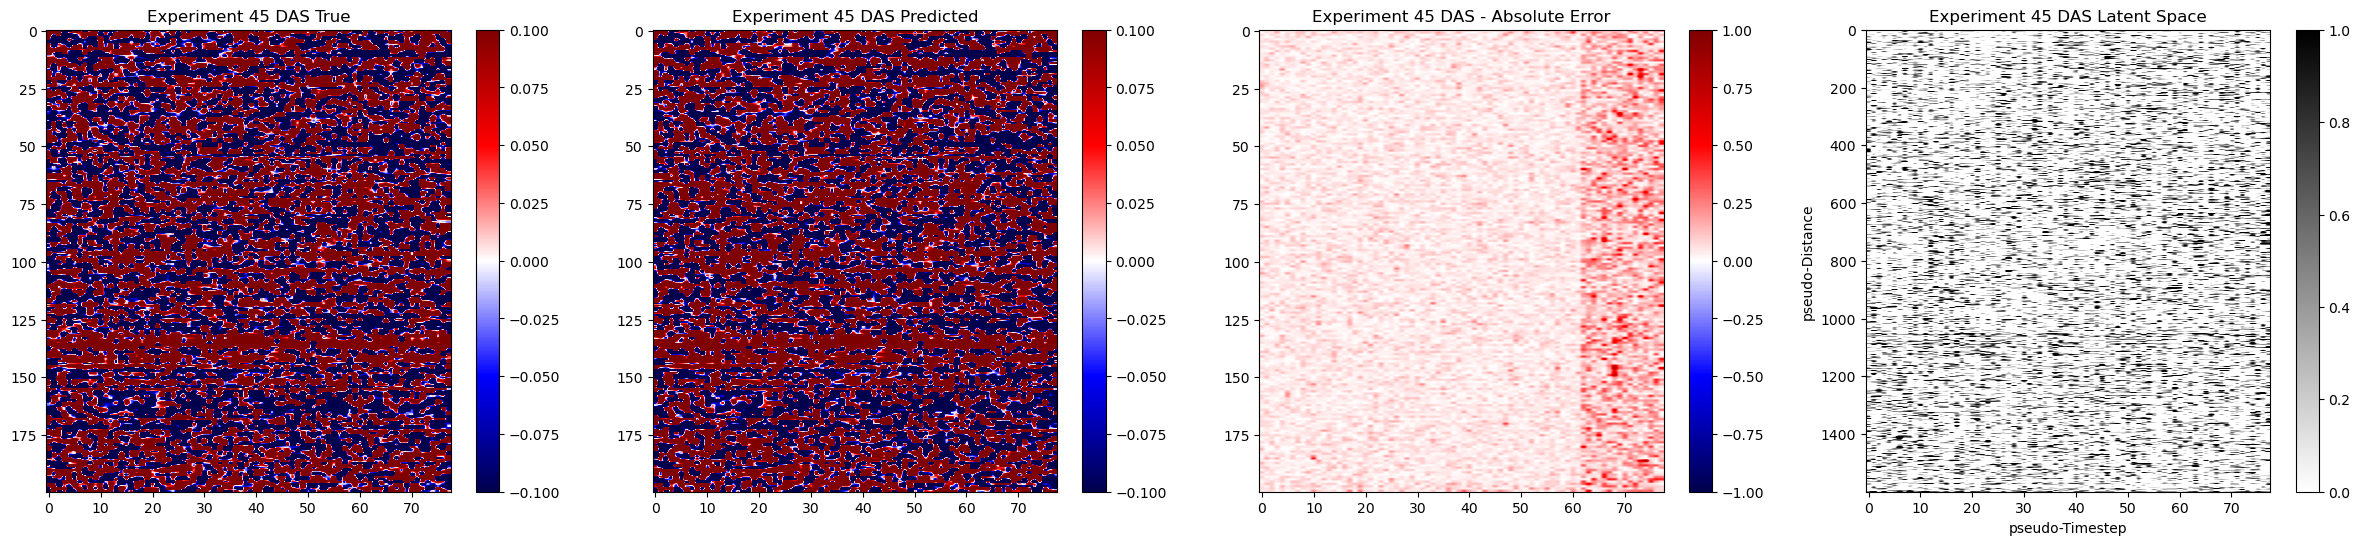

In [8]:
das_m2m, das_m2z = das_Unet()
print('AutoEncoder # of parameters: {:,}'.format(das_m2m.count_params()))
print('    Encoder # of parameters: {:,}'.format(das_m2z.count_params()))

das_m2m.compile(optimizer=Nadam(1e-3), loss='mse', metrics=['mse'])
fit_das = das_m2m.fit(das45, das45,
                        shuffle          = True,
                        epochs           = 150,
                        batch_size       = 10,
                        validation_split = 0.2,
                        verbose          = 0)
plot_loss(fit_das, figsize=(4,3))

das45_pred = das_m2m.predict(das45).squeeze().astype('float64')
das45_z = das_m2z.predict(das45).squeeze().astype('float64')
print('SSIM = {:.2f}'.format(100*image_ssim(das45.squeeze().T, das45_pred.T, data_range=1.0)))
print('MSE  = {:.3e}'.format(image_mse(das45.squeeze().T, das45_pred.T)))
print('PSNR = {:.2f}'.format(image_psnr(das45.squeeze().T, das45_pred.T, data_range=2)))

plot_true_pred_z(das45, das45_pred, das45_z, filenum='45 DAS')

AutoEncoder # of parameters: 45,333
    Encoder # of parameters: 25,220
3/3 [==============================] - 0s 7ms/step
SSIM = 89.98
MSE  = 8.784e-03
PSNR = 26.58


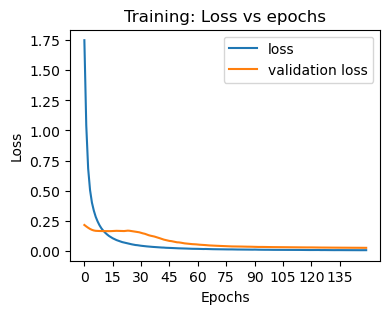

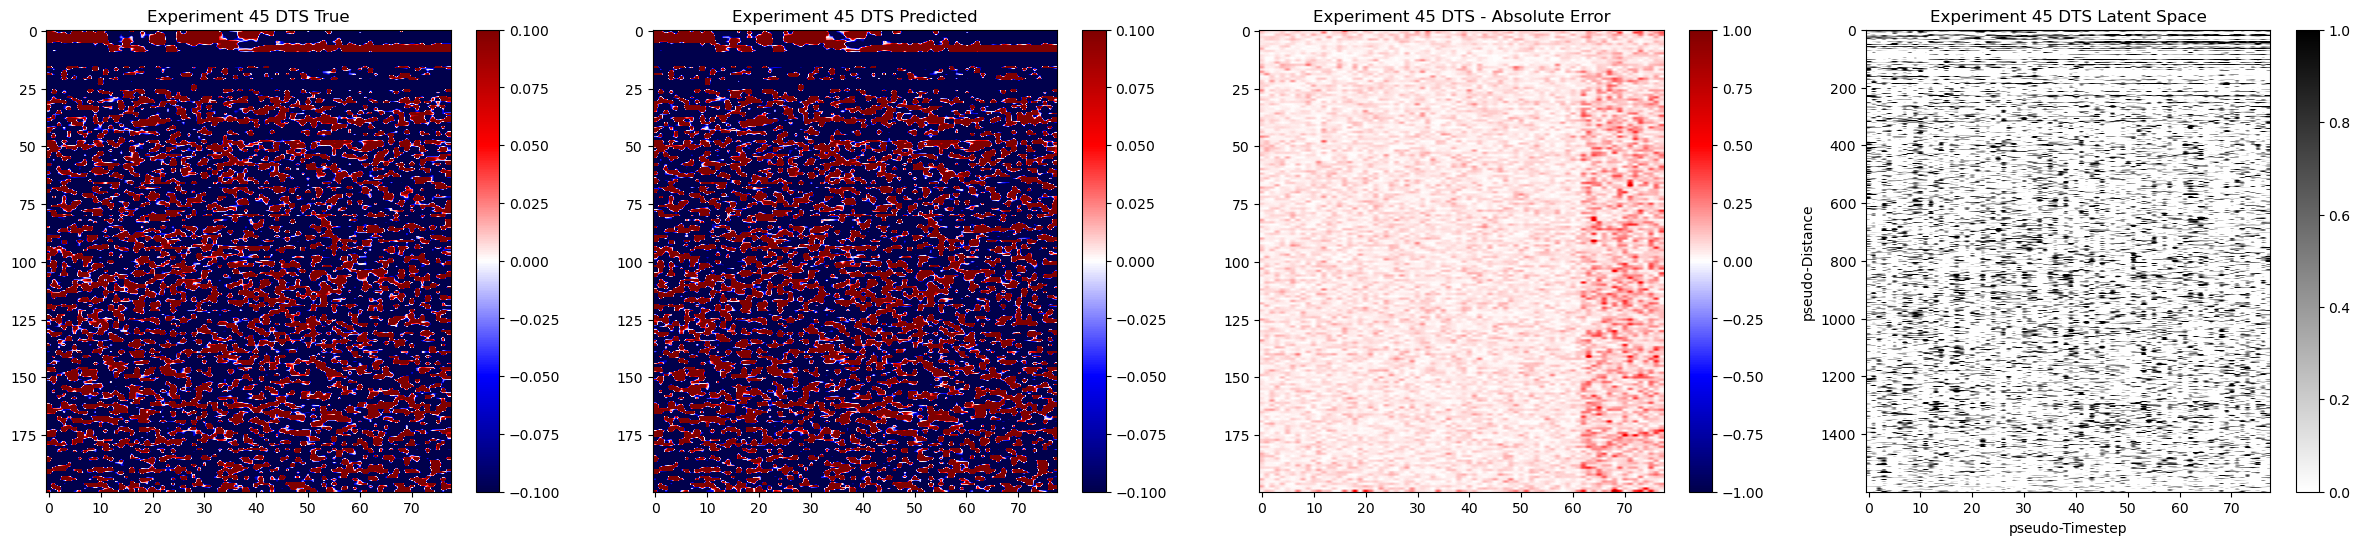

In [9]:
dts_m2m, dts_m2z = dts_Unet()
print('AutoEncoder # of parameters: {:,}'.format(dts_m2m.count_params()))
print('    Encoder # of parameters: {:,}'.format(dts_m2z.count_params()))

dts_m2m.compile(optimizer=Nadam(1e-3), loss='mse', metrics=['mse'])
fit_dts = dts_m2m.fit(dts45, dts45,
                        shuffle          = True,
                        epochs           = 150,
                        batch_size       = 10,
                        validation_split = 0.2,
                        verbose          = 0)
plot_loss(fit_dts, figsize=(4,3))

dts45_pred = dts_m2m.predict(dts45).squeeze().astype('float64')
dts45_z = dts_m2z.predict(dts45).squeeze().astype('float64')
print('SSIM = {:.2f}'.format(100*image_ssim(dts45.squeeze().T, dts45_pred.T, data_range=1.0)))
print('MSE  = {:.3e}'.format(image_mse(dts45.squeeze().T, dts45_pred.T)))
print('PSNR = {:.2f}'.format(image_psnr(dts45.squeeze().T, dts45_pred.T, data_range=2)))

plot_true_pred_z(dts45, dts45_pred, dts45_z, filenum='45 DTS')

***

MSE:  6.59e-09
SSIM: 1.000


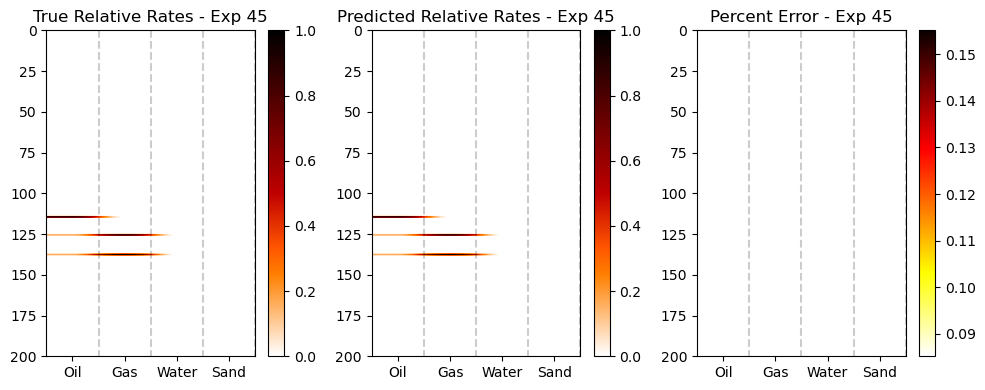

Ridge()

In [10]:
make_flowpred_from_dual_latent(das45_z, dts45_z, flow45, expnum='45', method=Ridge())

Shapes - z_DAS: (93, 25, 64) | z_DTS: (93, 25, 64)
MSE:  4.18e-09
SSIM: 1.000


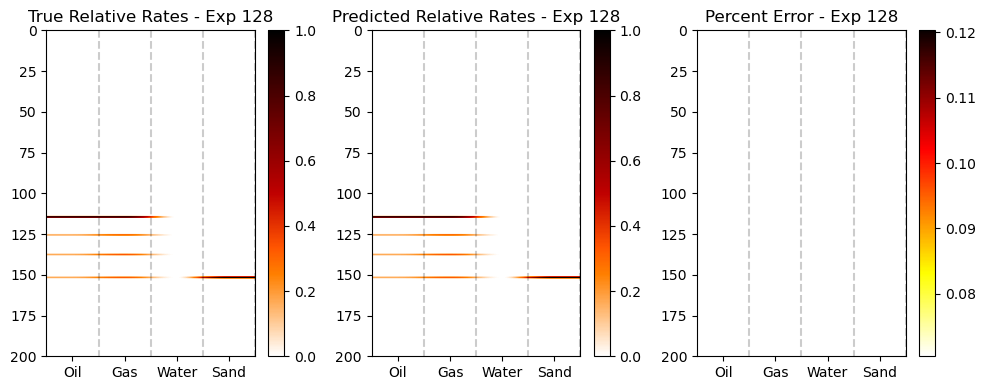

In [11]:
# Transfer Learning
transfer_learning_predictions_dual(das128, dts128, flow128, das_m2z, dts_m2z, expnum='128', method=Ridge())

***
## Make Dictionaries from data and models

In [12]:
flow_dict = {'45':flow45, '48':flow48, '54':flow54, '64':flow64, '109':flow109, '128':flow128}

In [13]:
models = {'das': {'m2m':das_m2m, 'm2z':das_m2z},
          'dts': {'m2m':dts_m2m, 'm2z':dts_m2z}}

In [14]:
all_data = {'das': {'45':das45, '48':das48, '54':das54, '64':das64, '109':das109, '128':das128}, 
            'dts': {'45':dts45, '48':dts48, '54':dts54, '64':dts64, '109':dts109, '128':dts128}}

***
## Single Latent Space

In [15]:
single_latents = make_single_latents(models, all_data)

DAS Latent Spaces: 
---------------------------------------------------------
45: (78, 25, 64) | 48: (78, 25, 64)   | 54: (114, 25, 64)
64: (82, 25, 64) | 109: (106, 25, 64) | 128: (93, 25, 64)
---------------------------------------------------------

DTS Latent Spaces: 
---------------------------------------------------------
45: (78, 25, 64) | 48: (78, 25, 64)   | 54: (114, 25, 64)
64: (82, 25, 64) | 109: (106, 25, 64) | 128: (93, 25, 64)
---------------------------------------------------------


DAS only: MSE=3.34e-08, SSIM=1.000
DTS only: MSE=2.58e-08, SSIM=1.000
Dual:     MSE=5.14e-09, SSIM=1.000


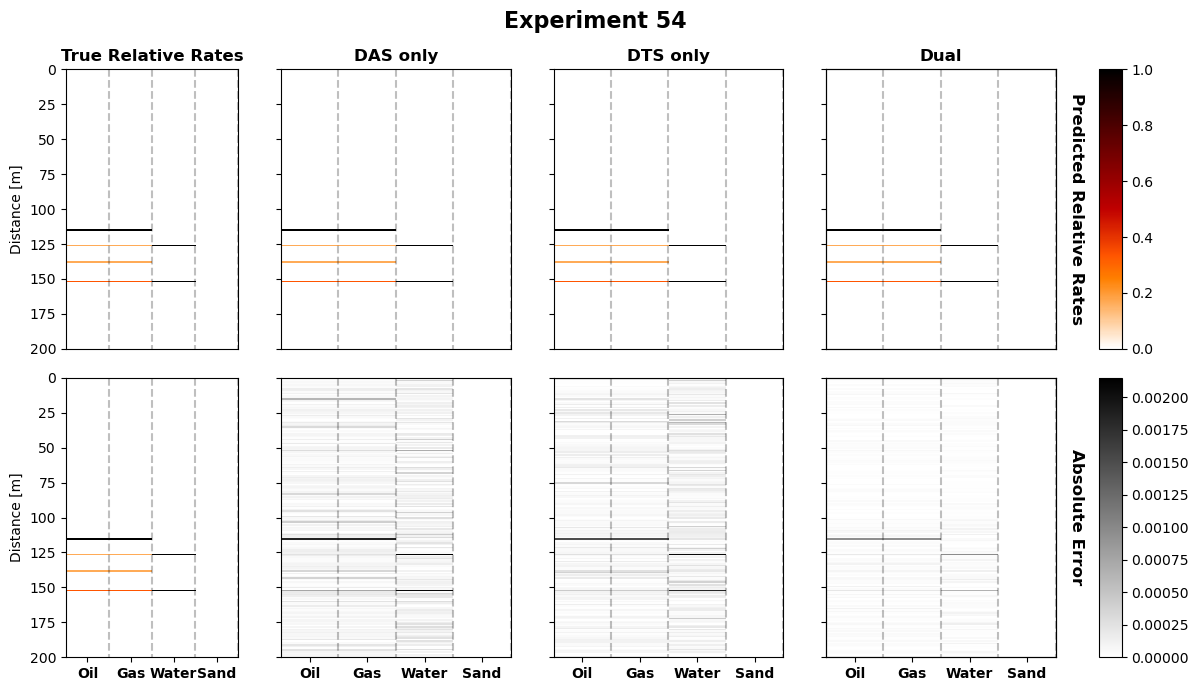

In [16]:
make_flowpred_from_single_latent(single_latents, flow_dict, expnum='54', method=Ridge())

***
## Uncertainty Quantification

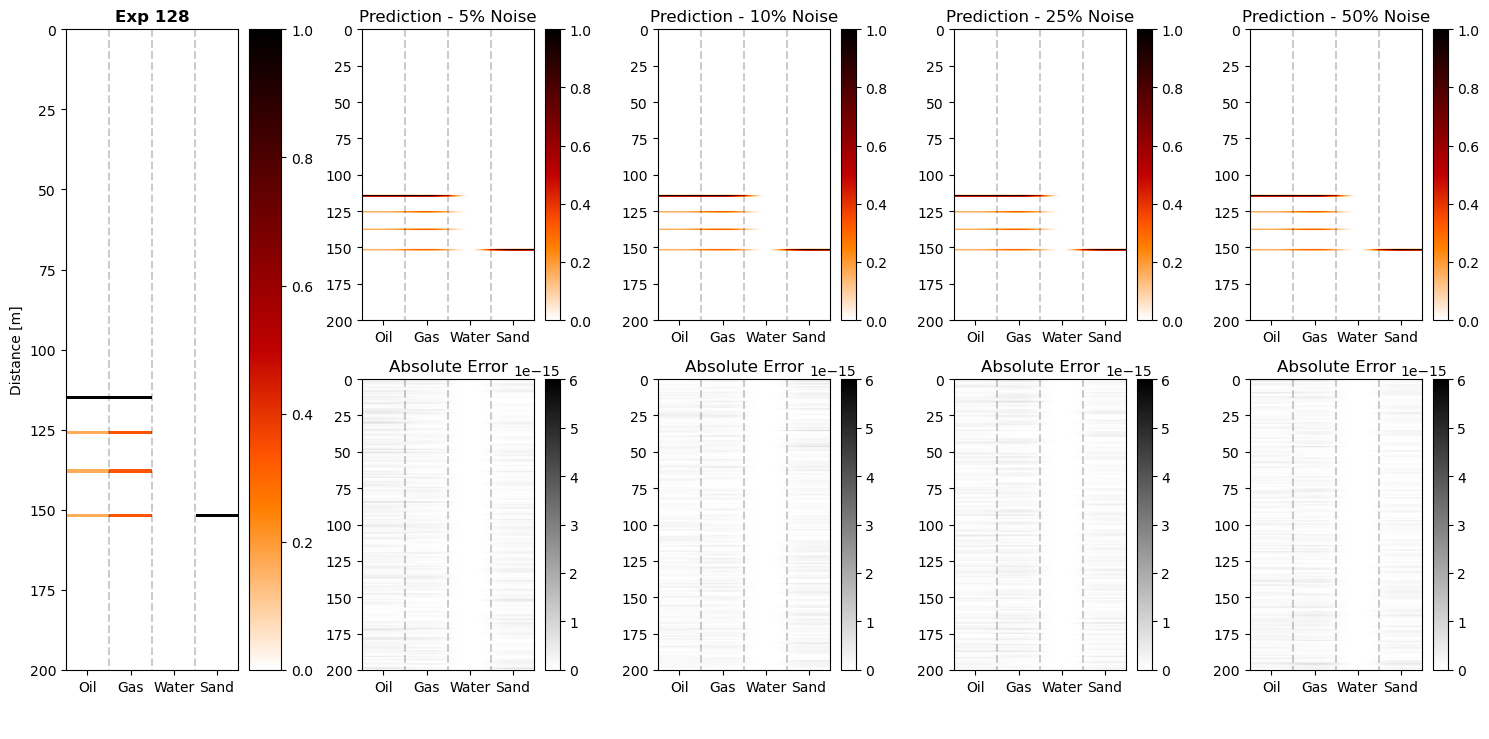

In [17]:
make_uq_pred_dual('128', all_data, models, flow_dict)

***
# END